In [ ]:
import math
import matplotlib.pyplot as plt
from xsigmamodules.Util import (
    blackScholes,
    bachelier,
    yearMonthDay,
    dayCountConvention,
    day_count_convention_enum,
    datetimeHelper,
    tenor,
    events,
    business_day_convention_enum,
    day_count_convention_enum,
    currency_convention_enum,
    calendar,
    implied_volatility_enum,
    delta_atm_convention_enum,
    delta_convention_enum,
    strangle_convention_enum,
    businessDayConventionFromConvention,
)
from xsigmamodules.Math import (
    normalDistribution,
    interpolation_enum,
    solverOptionsCeres,
    solverOptionsLm,
    solverOptionsNlopt,
    nlopt_algo_name,
)

from xsigmamodules.Market import (
    anyContainer,
    anyObject,
    anyId,
    fxForwardMarket,
    fxForwardId,
    interpolation_wing_time_enum,
    interpolatorMeanReverting,
    interpolatorMeanRevertingConfig,
    interpolatorMeanRevertingConfigBuilder,
    discountCurve,
    discountCurveId,
    discountCurveFlat,
    fxVolatility,
    fxVolatilityId,
    fxVolatilityQuadraticSmile,
    fxVolatilityQuadraticSmileBuilder,
    interpolatorMeanRevertingConfig,
    fxVolatilityInterpolationConfig,
    fxVolatilityInterpolationConfigId,
    fxVolatilityInterpolationConfigBuilder,
    fxVolatilityCalibrationTargets,
    fxVolatilityCalibrationTargetsBuilder,
    fxVolatilityCalibrationTargetsId,
    fxVolatilityModelConfig,
    fxVolatilityModelConfigId,
    atmVolatilityQuote,
    riskReversalVolatilityQuote,
    strangleVolatilityQuote,
    wingExtrapolationConfig,
    wingExtrapolationConfigBuilder,
    fxVolatilityExtendedSvi,
    fxVolatilityExtendedSviBuilder,
    valuationDatetimeId,
    valuationDatetime,
    volatility_model_enum,
)
from xsigmamodules.util.misc import xsigmaGetDataRoot, xsigmaGetTempDir
from xsigmamodules.util.numpy_support import numpyToXsigma
import numpy as np

valuation_date = yearMonthDay(2020, 1, 21).to_datetime()
holidays = calendar()
Bday_convention_enum = business_day_convention_enum.FOLLOWING
convention = dayCountConvention(day_count_convention_enum.ACT_365, holidays)
adjustement = businessDayConventionFromConvention(Bday_convention_enum, holidays)

for_curv = discountCurveFlat(valuation_date, 0.01, convention)

dom_curve = discountCurveFlat(valuation_date, 0.02, convention)

fx_fwd = fxForwardMarket(valuation_date, 1.65, dom_curve, for_curv)

calibration_tenors = [
    "1B",
    "1W",
    "2W",
    "3W",
    "1M",
    "2M",
    "3M",
    "4M",
    "5M",
    "6M",
    "9M",
    "1Y",
    "18M",
    "2Y",
    "3Y",
    "5Y",
    "7Y",
    "10Y",
]
vols_atm_mkt = [
    0.0722,
    0.0649,
    0.0624,
    0.0639,
    0.0645,
    0.0632,
    0.0629,
    0.0625,
    0.0623,
    0.0622,
    0.0622,
    0.0621,
    0.0640,
    0.0661,
    0.0690,
    0.0742,
    0.0808,
    0.0819,
]
vols_rr25_mkt = [
    0.0120,
    0.0092,
    0.0088,
    0.0090,
    0.0091,
    0.0092,
    0.0095,
    0.0092,
    0.0089,
    0.0086,
    0.0085,
    0.0084,
    0.0103,
    0.0088,
    0.0084,
    0.0075,
    0.0081,
    0.0084,
]
vols_ms25_mkt = [
    0.0015,
    0.0015,
    0.0015,
    0.0015,
    0.0016,
    0.0017,
    0.0019,
    0.0020,
    0.0020,
    0.0020,
    0.0021,
    0.0021,
    0.0030,
    0.0034,
    0.0034,
    0.0036,
    0.0037,
    0.0036,
]
vols_rr10_mkt = [
    0.0189,
    0.0171,
    0.0164,
    0.0164,
    0.0161,
    0.0164,
    0.0170,
    0.0164,
    0.0160,
    0.0156,
    0.0155,
    0.0155,
    0.0196,
    0.0167,
    0.0162,
    0.0148,
    0.0163,
    0.0169,
]
vols_ms10_mkt = [
    0.0055,
    0.0050,
    0.0048,
    0.0049,
    0.0049,
    0.0054,
    0.0060,
    0.0061,
    0.0062,
    0.0063,
    0.0066,
    0.0066,
    0.0101,
    0.0113,
    0.0116,
    0.0118,
    0.0121,
    0.0115,
]

vols_atm_mkt_expiries = []
variances = []
dates = []
for i, t in enumerate(calibration_tenors):
    expiry = adjustement.advance(valuation_date, t)
    dates.append(expiry)
    vols_atm_mkt_expiries.append(convention.fraction(valuation_date, expiry))
    variances.append(
        vols_atm_mkt[i] * vols_atm_mkt[i] * convention.fraction(valuation_date, expiry)
    )

event = events(
    [
        yearMonthDay(2030, 3, 13).to_datetime(),
        yearMonthDay(2030, 7, 13).to_datetime(),
        yearMonthDay(2030, 1, 13).to_datetime(),
    ],
    [1.0, 1.0, 1.0],
)
short_term_atm_interpolation = (
    interpolatorMeanRevertingConfigBuilder()
    .with_events(event)
    .with_sigma_limit(0.15)
    .with_sigma_initial(0.19)
    .with_sigma_short(0.2)
    .with_lambda(0.99)
    .with_lambda_short(0.88)
    .with_weekend_weight(1.0)
    .build()
)

interpolator = interpolatorMeanReverting(
    valuation_date, dates, variances, short_term_atm_interpolation
)

extrapolation_config = (
    wingExtrapolationConfigBuilder()
    .with_delta(0.1)
    .with_volatility_multiplier(2.0)
    .with_max_volatility_multiplier(1.1)
    .build()
)

current_date = valuation_date
last_date = adjustement.advance(valuation_date, "10Y")

interpolated_vols = []
expiries = []
while adjustement.advance(current_date, "1w") <= last_date:
    # Advance the current_date by 1 month each time
    current_date = adjustement.advance(current_date, "1w")
    T = convention.fraction(valuation_date, current_date)
    vol = math.sqrt(interpolator.interpolate(current_date) / T)
    interpolated_vols.append(vol)
    expiries.append(T)

volatility_targets = (
    fxVolatilityCalibrationTargetsBuilder()
    .with_valuation_date(valuation_date)
    .with_tenors(calibration_tenors)
    .with_holidays(holidays)
    .with_business_day_convention(Bday_convention_enum)
    .with_vols_atm(vols_atm_mkt)
    .with_vols_rr25(vols_rr25_mkt)
    .with_vols_rr10(vols_rr10_mkt)
    .with_vols_ms25(vols_ms25_mkt)
    .with_vols_ms10(vols_ms10_mkt)
    .with_booking_convention(currency_convention_enum.DOMESTIC)
    .with_facing_convention(currency_convention_enum.DOMESTIC)
    .with_delta_atm_convention(delta_atm_convention_enum.ZERO_DELTA_STRADDLE)
    .with_delta_convention(delta_convention_enum.FORWARD)
    .with_strangle_convention(strangle_convention_enum.THEORETICAL)
    .build()
)

calibration_expiries = []
for i, t in enumerate(calibration_tenors):
    expiry = adjustement.advance(valuation_date, t)
    calibration_expiries.append(convention.fraction(valuation_date, expiry))

interpolation_config = (
    fxVolatilityInterpolationConfigBuilder()
    .with_wing_capping_config(extrapolation_config)
    .with_short_term_interpolation_config(short_term_atm_interpolation)
    .with_interpolation_switching_tenor("2Y")
    .with_long_term_interpolation(interpolation_enum.LINEAR)
    .with_wing_interpolation(interpolation_wing_time_enum.CALL_PUT_VARIANCE)
    .build()
)

fx_volatility_call_put = (
    fxVolatilityQuadraticSmileBuilder()
    .with_valuation_date(valuation_date)
    .with_fx_forward(fx_fwd)
    .with_volatility_targets(volatility_targets)
    .with_interpolation_config(interpolation_config)
    .build()
)


interpolation_config = (
    fxVolatilityInterpolationConfigBuilder()
    .with_wing_capping_config(extrapolation_config)
    .with_short_term_interpolation_config(short_term_atm_interpolation)
    .with_interpolation_switching_tenor("2Y")
    .with_long_term_interpolation(interpolation_enum.CUBIC_HERMITE)
    .with_wing_interpolation(interpolation_wing_time_enum.INSTRUMENT_VOL)
    .build()
)

fx_volatility_instrument = (
    fxVolatilityQuadraticSmileBuilder()
    .with_valuation_date(valuation_date)
    .with_fx_forward(fx_fwd)
    .with_volatility_targets(volatility_targets)
    .with_interpolation_config(interpolation_config)
    .build()
)

interpolation_config = (
    fxVolatilityInterpolationConfigBuilder()
    .with_wing_capping_config(extrapolation_config)
    .with_short_term_interpolation_config(short_term_atm_interpolation)
    .with_interpolation_switching_tenor("2Y")
    .with_long_term_interpolation(interpolation_enum.LINEAR)
    .with_wing_interpolation(interpolation_wing_time_enum.FIXED_STRIKE)
    .build()
)

fx_volatility_delta = (
    fxVolatilityQuadraticSmileBuilder()
    .with_valuation_date(valuation_date)
    .with_fx_forward(fx_fwd)
    .with_volatility_targets(volatility_targets)
    .with_interpolation_config(interpolation_config)
    .build()
)


interpolation_config_model = (
    fxVolatilityInterpolationConfigBuilder()
    .with_wing_capping_config(extrapolation_config)
    .with_short_term_interpolation_config(short_term_atm_interpolation)
    .with_interpolation_switching_tenor("2Y")
    .with_long_term_interpolation(interpolation_enum.CUBIC_HERMITE)
    .with_wing_interpolation(interpolation_wing_time_enum.INSTRUMENT_VOL)
    .build()
)

options = solverOptionsLm(500, 1e-14, 1e-14, 1e-14)
fx_volatility_svi = (
    fxVolatilityExtendedSviBuilder()
    .with_valuation_date(valuation_date)
    .with_fx_forward(fx_fwd)
    .with_volatility_targets(volatility_targets)
    .with_interpolation_config(interpolation_config_model)
    .with_options(options)
    .build()
)

expiry = adjustement.advance(valuation_date, "7m")
T = convention.fraction(valuation_date, expiry)
forward = fx_fwd.forward(expiry)

n = 128
strike_ratio = np.linspace(0.75, 1.25, n)
model_call_put = fx_volatility_call_put.model(expiry)
model_instrument = fx_volatility_instrument.model(expiry)
model_delta = fx_volatility_delta.model(expiry)
model_svi = fx_volatility_svi.model(expiry)

vol_call_put = np.zeros_like(strike_ratio)
vol_instrument = np.zeros_like(strike_ratio)
vol_delta = np.zeros_like(strike_ratio)
vol_svi = np.zeros_like(strike_ratio)

for i, k in enumerate(strike_ratio):
    vol_call_put[i] = model_call_put.implied_volatility(
        1.0, k, T, implied_volatility_enum.LOG_NORMAL
    )
    vol_instrument[i] = model_instrument.implied_volatility(
        forward, k * forward, T, implied_volatility_enum.LOG_NORMAL
    )
    vol_delta[i] = model_delta.implied_volatility(
        forward, k * forward, T, implied_volatility_enum.LOG_NORMAL
    )
    vol_svi[i] = model_svi.implied_volatility(
        forward, k * forward, T, implied_volatility_enum.LOG_NORMAL
    )


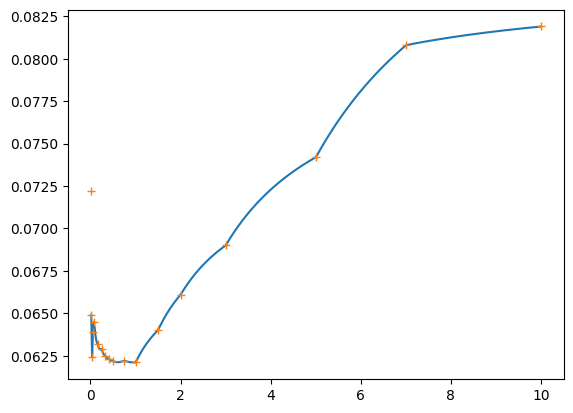

In [2]:
plt.plot(expiries, interpolated_vols)
plt.plot(vols_atm_mkt_expiries, vols_atm_mkt, "+")
plt.show()

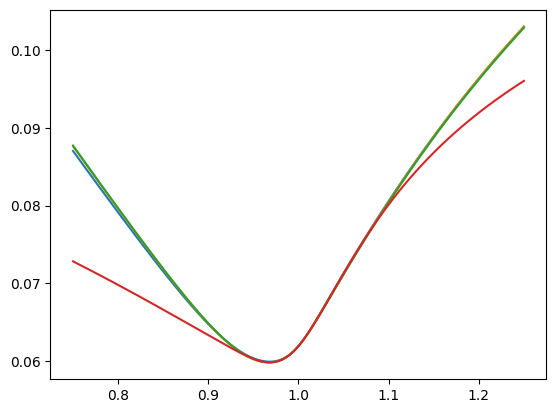

In [3]:
plt.plot(strike_ratio, vol_call_put)
plt.plot(strike_ratio, vol_instrument)
plt.plot(strike_ratio, vol_delta)
plt.plot(strike_ratio, vol_svi)
plt.show()

In [4]:
fxVolatilityInterpolationConfig.write_to_json(
    "fxVolatilityInterpolationConfig.json", interpolation_config
)
fxVolatilityQuadraticSmile.write_to_json(
    "fxVolatilityQuadraticSmile.json", fx_volatility_instrument
)
fxVolatilityCalibrationTargets.write_to_json(
    "fxVolatilityCalibrationTargets.json", volatility_targets
)

In [5]:
obj1 = fxVolatilityInterpolationConfig.read_from_json(
    "fxVolatilityInterpolationConfig.json"
)
obj2 = fxVolatilityQuadraticSmile.read_from_json("fxVolatilityQuadraticSmile.json")
obj3 = fxVolatilityCalibrationTargets.read_from_json(
    "fxVolatilityCalibrationTargets.json"
)

In [6]:
from xsigmamodules.market import market_data

In [7]:
model_config=fxVolatilityModelConfig(volatility_model_enum.EXTENDED_SVI, options)

In [8]:
market=anyContainer()
market.insert(
        anyId(valuationDatetimeId()), anyObject(valuationDatetime(valuation_date))
    )
fx_forward_id=fxForwardId(discountCurveId("EUR", "EUR.ESTR.1b"), discountCurveId("USD", "USD.SOFR.1b"))
id=fxVolatilityId(fx_forward_id)

market.insert(
        anyId(fx_forward_id), anyObject(fx_fwd)
    )
market.insert(
        anyId(fxVolatilityCalibrationTargetsId(id)), anyObject(volatility_targets)
    )
market.insert(
        anyId(fxVolatilityModelConfigId(id)), anyObject(model_config)
    )
market.insert(
        anyId(fxVolatilityInterpolationConfigId(id)), anyObject(interpolation_config_model)
    )

In [9]:
id=fxVolatilityId(fxForwardId(discountCurveId("EUR", "EUR.ESTR.1b"),discountCurveId("USD", "USD.SOFR.1b")))

In [10]:
market_data.discover(market, [anyId(id)])
fxVolatility.static_cast(market.get(anyId(id)))

<xsigmamodules.Market.fxVolatility(0x000001B2D69CB740) at 0x000001B2D69CB740>